In [35]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_MODEL_NAME = os.getenv("GOOGLE_MODEL_NAME", "gemini-pro") 

from langchain_google_genai import ChatGoogleGenerativeAI

In [36]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ChatMessage



In [37]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

def load_document_content(file_path):
    try:
        # Load documents from the file using TextLoader
        loader = TextLoader(file_path)
        documents = loader.load()

        # Split text into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)

        # Concatenate the chunks into a single context string
        context = "\n".join([doc.page_content for doc in docs])
        return context
    except Exception as e:
        return f"Error loading document content: {e}"

file_name = 'topic_material.txt'
file_path = os.path.join("data", file_name)
context = load_document_content(file_path)



In [38]:
context

'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic behavior, and then\nredefine it for more specialized entities that 

In [39]:
GREETING_PROMPT = """
You are an AI Tutor. You are given a topic and a subject.
You need to create a greeting message for the student and ask them what they want to learn based on the subject and topic.
Keep the greeting short and concise.

Subject: {subject}
Topic: {topic}
"""

QUESTION_GUARDING_PROMPT = """
You are an AI Tutor. Based on the content of the topic, 
you need to decide if the student's question is related to the topic.
For educational purpose, it is ok to be related but not exactly the same topic.
If it is, respond "Pass".  
If it is not, respond "Fail" 

Student Question: {question}
Content of the topic: {context}
"""

QUESTION_ANSWERING_PROMPT = """
You are an AI Tutor. You are given a question and a topic.
You need to answer the question based on the context.
After finishing explaining, ask the student a question to check their understanding.

Question: {question}
Context: {context}
"""




In [40]:
from typing import TypedDict, Annotated, datetime
from langgraph.graph.message import add_messages


llm = ChatGoogleGenerativeAI(model="gemini-pro")

class AgentState(TypedDict):
    subject: str
    topic: str
    context: str
    messages: Annotated[list, add_messages]
    start_time: datetime
    

def greeting(state: AgentState):
    subject = state["subject"]
    topic = state["topic"]
    messages = state["messages"]

    greeting_prompt = GREETING_PROMPT.format(subject=subject, topic=topic)
    messages= [HumanMessage(content=greeting_prompt.format(subject=subject, topic=topic))]
    response = llm.invoke(messages)
    return {"messages": response}


def question_guarding(state:AgentState):
    print("Question guarding: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_GUARDING_PROMPT.format(question=question, context=context))
    content = response.content
    if content.startswith("Pass"):
        print("Pass")
        return "Pass"
    # elif content.startswith("Fail:"):
    #     follow_up_question = content.split(":")[1]
    #     # return {"messages": [AIMessage(content=follow_up_question)]}
    #     # state["messages"].append(AIMessage(content=follow_up_question))
    #     return "Fail"

    else:
        print("Fail")
        # follow_up_question = content.split(":")[1]
        # state["messsage"].append(AIMessage(content=follow_up_question))
        return "Fail"
        # return {"messages": [HumanMessage(content="Check again for pass or fail question!")]}

def student_input(state:AgentState):
    print(state["messages"][-1].content)
    return state

def reask_question(state:AgentState):
    return {"messages": [AIMessage(content="Your question is not related to the topic. Please ask a question related to the topic.")]}


def answer_question(state:AgentState):
    # print("Answer the question: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_ANSWERING_PROMPT.format(question=question, context = context))
    result=response.content
    return {"messages": [AIMessage(content=result)]}





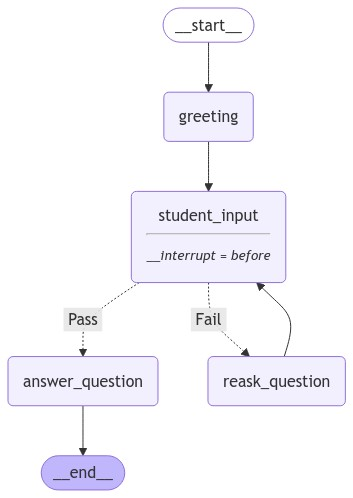

In [59]:
from langgraph.graph import START,END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("greeting", greeting)
workflow.add_node("student_input", student_input)
# workflow.add_node("question_guarding", question_guarding)
workflow.add_node("answer_question", answer_question)
workflow.add_node("reask_question", reask_question)

workflow.add_edge(START, "greeting")
workflow.add_edge("greeting", "student_input")
workflow.add_edge("reask_question", "student_input")

workflow.add_conditional_edges(
    "student_input",
    question_guarding,
    {
        "Pass": "answer_question",
        "Fail": "reask_question"
    }
)

workflow.add_edge("answer_question", END)
# workflow.add_edge("student_input", "question_guarding")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input"])

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


### Initial greeting


In [60]:
# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': []}
{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'output_tokens': 41, 'total_tok

In [61]:
user_input = "what is python decorator?"

# We now update the state as if we are the student_input node
app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node="student_input")

# We can check the state
print("--State after update--")
print(app.get_state(thread))
print("--Next node=-")
print(app.get_state(thread).next)
print("--Node values--")
print(app.get_state(thread).values)
print("--Messages--")
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()


Question guarding:  what is python decorator?
Fail
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'outp

In [62]:
for event in app.stream(None, thread, stream_mode="values"):
    # print(event)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is python decorator?
================================== Ai Message ==================================

Your question is not related to the topic. Please ask a question related to the topic.


In [63]:
# Get user input
# try:
#     user_input = input("Ask question:")
# except:
user_input = "what is Polymorphism?"

# We now update the state as if we are the student_input node
app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node="student_input")

# We can check the state
print("--State after update--")
print(app.get_state(thread))
print("--Next node=-")
print(app.get_state(thread).next)
print("--Node values--")
print(app.get_state(thread).values)
print("--Messages--")
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()


Question guarding:  what is Polymorphism?
Pass
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello there! Welcome to my Java tutoring session on Polymorphism. I'm here to help you understand the concept of polymorphism in Java. What specific areas of polymorphism would you like to learn about today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-80d48234-5f0a-40f6-8de8-d7d70a188903-0', usage_metadata={'input_tokens': 63, 'output_t

In [64]:
for event in app.stream(None, thread, stream_mode="values"):
    # print(event)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is Polymorphism?
================================== Ai Message ==================================

**Definition of Polymorphism**

Polymorphism is a concept in object-oriented programming that allows different classes to have methods with the same name, but with different implementations. This allows objects of different classes to respond to the same message in different ways.

In the example of the CommissionEmployee and BasePlusCommisionEmployee classes, the toString() method behaves differently when applied to different objects because each class has its own implementation of the method.

**Understanding Polymorphism**

To understand polymorphism, consider the following scenario:

You have a class called "Shape" that represents the abstract concept of a geometric shape. You then create subclasses of Shape, such as "Circle" and "Rectangle". Each subclass inherits the properties and methods of the 